In [1]:
# fit_many_transects - Loop through transects and collect fits

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LinearRegression, RANSACRegressor, TheilSenRegressor
from scipy import stats
import statsmodels.api as sm
import pymc as pm

In [2]:
data_dir = 'C:/crs/proj/2025_shoreline_fits/'
fn = 'Northshore_LT_intersects.csv'
df = pd.read_csv(data_dir+fn)

# Convert to datetime format
df["date"] = pd.to_datetime(df["ShorelineI"], format="%m/%d/%Y")

# Function to convert datetime to decimal year
def datetime_to_decimal_year(dt):
    year = dt.year
    start_of_year = pd.Timestamp(f"{year}-01-01")
    end_of_year = pd.Timestamp(f"{year+1}-01-01")
    decimal_year = year + (dt - start_of_year).total_seconds() / (end_of_year - start_of_year).total_seconds()
    return decimal_year

# Apply function to convert each date
df["decimal_year"] = df["date"].apply(datetime_to_decimal_year)
df

,FID,OBJECTID,TransectID,TransOrder,BaselineID,ShorelineI,Distance,IntersectX,IntersectY,Uncertaint,Bias_Dista,BIAS,BIAS_X,BIAS_Y,Bias_Uncer,date,decimal_year
0,0,1,1,1,1,07/01/1855,34.976190,352128.892960,4.750413e+06,10.80,41.522127,6.545937,352135.016503,4.750410e+06,11.257508,1855-07-01,1855.495890
1,1,2,1,1,1,07/01/1953,-27.896967,352070.076869,4.750435e+06,10.80,-21.351030,6.545937,352076.200410,4.750432e+06,11.257508,1953-07-01,1953.495890
2,2,3,1,1,1,09/30/2000,37.442543,352131.200165,4.750412e+06,2.26,37.442543,6.545937,352131.200165,4.750412e+06,2.260000,2000-09-30,2000.745902
3,3,4,2,2,1,07/01/1855,16.848559,352094.265039,4.750372e+06,10.80,23.394496,6.545937,352100.388583,4.750370e+06,11.257508,1855-07-01,1855.495890
4,4,5,2,2,1,07/01/1944,4.646185,352082.850052,4.750376e+06,10.80,11.192122,6.545937,352088.973596,4.750374e+06,11.257508,1944-07-01,1944.497268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27231,27231,27036,3740,3740,39,07/01/1893,-2.350970,337344.903873,4.691653e+06,10.80,-2.349970,0.001000,337344.902916,4.691653e+06,10.800000,1893-07-01,1893.495890
27232,27232,27037,3740,3740,39,07/01/1938,-11.054914,337353.232937,4.691656e+06,10.80,-11.053914,0.001000,337353.231980,4.691656e+06,10.800000,1938-07-01,1938.495890
27233,27233,27038,3740,3740,39,07/01/1978,-10.946378,337353.129075,4.691656e+06,5.10,-10.945378,0.001000,337353.128118,4.691656e+06,5.100000,1978-07-01,1978.495890
27234,27234,27039,3740,3740,39,10/01/1994,-5.199820,337347.630023,4.691654e+06,5.10,-5.198820,0.001000,337347.629066,4.691654e+06,5.100000,1994-10-01,1994.747945


In [3]:
def r2_from_predictions( x, y, slope, intercept ):
    # For fits that don't return r2, calculate from the data and the fit
    # Compute predicted values
    y_pred = slope * x + intercept
    
    # Compute r2
    SS_total = np.sum((y - np.mean(y)) ** 2)  # Total Sum of Squares
    SS_residual = np.sum((y - y_pred) ** 2)   # Residual Sum of Squares
    r_squared = 1 - (SS_residual / SS_total)
    return r_squared

In [4]:
transects = np.unique(df['TransectID'])
n_list=[]
t_list=[]
yr_start_list=[]
yr_end_list=[]
lat_list=[]
lon_list=[]
OLSslope_list=[]
OLSslope_CIlow_list=[]
OLSslope_CIhi_list=[]
OLSr2_list=[]
WLSslope_list=[]
WLSslope_CIlow_list=[]
WLSslope_CIhi_list=[]
WLSr2_list=[]
TSslope_list=[]
TSslope_CIlow_list=[]
TSslope_CIhi_list=[]
TSr2_list=[]
RANslope_list = []
RANr2_list = []

# Pre-filter the dataframe to keep only rows where decimal_year >= 1970
dff = df[df["decimal_year"] >= 1970]

for tid in dff["TransectID"].unique():  # Iterate only over existing TransectIDs
    tdf = dff[dff["TransectID"] == tid].sort_values(by="decimal_year")

    if len(tdf) >= 3:  # Ensure at least 3 valid rows
        x = tdf['decimal_year'].values - 1970
        y = tdf['Bias_Dista'].values
        yu = tdf['Bias_Uncer'].values
        
        t_list.append(tid)
        n_list.append(len(x))
        yr_start_list.append(tdf['decimal_year'].values[0])  # First valid year
        yr_end_list.append(tdf['decimal_year'].values[-1])  # Last year
        lon_list.append(tdf['IntersectX'].values[-1])  # Last latitude
        lat_list.append(tdf['IntersectY'].values[-1])  # Last longitude

        # Set up for statsmodels OLS and WLS
        # need a column of ones to fit intercept
        X = np.column_stack( (x, np.ones_like(x) ))
        weights = 1./( yu**2 )

        # Ordinary least-squares fit
        OLSfit = sm.OLS(y, X).fit()
        OLS_slope, OLS_intercept = OLSfit.params
        OLS_pvalues = OLSfit.pvalues        
        # Compute the 95% confidence interval for all parameters
        OLSconf_int = OLSfit.conf_int(alpha=0.05)  # Default is 95% CI       
        # Extract the slope's confidence interval
        OLSslope_CI = OLSconf_int[0]  # First row corresponds to the slope
        OLSslope_list.append( OLS_slope )
        OLSslope_CIlow_list.append( OLSslope_CI[0] )
        OLSslope_CIhi_list.append( OLSslope_CI[1] )
        OLSr2_list.append( OLSfit.rsquared )

        # Weighted least-squares fit
        WLSfit = sm.WLS(y, X, weights=weights).fit()
        WLS_slope, WLS_intercept = WLSfit.params
        WLS_pvalues = WLSfit.pvalues        
        # Compute the 95% confidence interval for all parameters
        WLSconf_int = WLSfit.conf_int(alpha=0.05)  # Default is 95% CI       
        # Extract the slope's confidence interval
        WLSslope_CI = WLSconf_int[0]  # First row corresponds to the slope
        WLSslope_list.append( WLS_slope )
        WLSslope_CIlow_list.append( WLSslope_CI[0] )
        WLSslope_CIhi_list.append( WLSslope_CI[1] )
        WLSr2_list.append( WLSfit.rsquared )

        #Theil-Sen fit
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.theilslopes.html
        res_theil = stats.theilslopes(y, x, alpha=0.95, method='separate' )
        TSslope_list.append( res_theil.slope )
        TSslope_CIlow_list.append( res_theil.low_slope ) 
        TSslope_CIhi_list.append( res_theil.high_slope )
        TSr2_list.append( r2_from_predictions( x, y, res_theil.slope, res_theil.intercept ) )
        
dft = pd.DataFrame({
    "transect": t_list,
    "N": n_list,
    "Year Start": yr_start_list,
    "Year End": yr_end_list,
    "Latitude": lat_list,
    "Longitude": lon_list,
    "OLS slope": OLSslope_list,
    "OLS slope CIlow": OLSslope_CIlow_list,
    "OLS slope CIhi": OLSslope_CIhi_list,
    "OLS r2": OLSr2_list,
    "WLS slope": WLSslope_list,
    "WLS slope CIlow": WLSslope_CIlow_list,
    "WLS slope CIlhi": WLSslope_CIhi_list,
    "WLS r2": WLSr2_list,
    "TS slope": TSslope_list,
    "TS slope CIlow": TSslope_CIlow_list,
    "TS slope CIlhi": TSslope_CIhi_list,
    "TS r2": TSr2_list
})

In [5]:
dft['slope std_dev'] = dft[['OLS slope', 'WLS slope', 'TS slope']].std(axis=1)


# Save to CSV
csv_filename = "slope_fits.csv"
dft.to_csv(data_dir+csv_filename, index=False)

# Print confirmation
print(f"DataFrame saved to {data_dir+csv_filename}")

DataFrame saved to C:/crs/proj/2025_shoreline_fits/slope_fits.csv


In [6]:
dft = pd.read_csv( data_dir+csv_filename )
dft.describe()

,transect,N,Year Start,Year End,Latitude,Longitude,OLS slope,OLS slope CIlow,OLS slope CIhi,OLS r2,WLS slope,WLS slope CIlow,WLS slope CIlhi,WLS r2,TS slope,TS slope CIlow,TS slope CIlhi,TS r2,slope std_dev
count,3572.000000,3572.000000,3572.000000,3572.000000,3.572000e+03,3572.000000,3572.000000,3572.000000,3572.000000,3.572000e+03,3572.000000,3572.000000,3572.000000,3.572000e+03,3572.000000,3572.000000,3572.000000,3572.000000,3572.000000
mean,1923.767917,5.080067,1985.282045,2018.545679,4.715083e+06,352155.843733,-0.031468,-0.895537,0.832602,4.115129e-01,0.028561,-1.209673,1.266795,3.450242e-01,0.020928,-1.124532,1.371469,0.196668,0.143046
std,1074.273789,1.079467,7.958469,0.646088,1.368420e+04,9504.147234,1.078881,1.853483,1.726915,3.293472e-01,1.274367,2.528863,2.636714,2.948933e-01,1.194149,2.948252,2.963616,0.465489,0.260083
min,39.000000,3.000000,1978.495890,2014.271233,4.689831e+06,336222.161239,-16.442397,-25.900848,-8.801601,3.499623e-08,-20.307694,-33.064836,-13.737688,4.474880e-07,-24.086276,-45.916222,-8.538476,-2.218952,0.000142
25%,1004.750000,4.000000,1978.495890,2018.630137,4.704028e+06,344905.826665,-0.145234,-0.978135,0.164435,9.317870e-02,-0.127408,-1.179308,0.240186,7.632373e-02,-0.101034,-1.054086,0.251370,-0.090358,0.025557
50%,1934.500000,5.000000,1978.495890,2018.641096,4.714722e+06,351785.756624,-0.001913,-0.418048,0.399898,3.530204e-01,0.028703,-0.530779,0.565918,2.757537e-01,0.031923,-0.473371,0.555372,0.141239,0.062446
75%,2854.250000,6.000000,1994.747945,2018.652740,4.725274e+06,360668.680881,0.176288,-0.158628,0.905446,7.245218e-01,0.236276,-0.239653,1.355869,5.704777e-01,0.220330,-0.172655,1.451642,0.577376,0.152881
max,3775.000000,7.000000,2008.289617,2018.676712,4.748576e+06,369572.733017,7.500614,1.906732,25.469905,9.998324e-01,12.502399,2.405889,38.313925,9.995475e-01,6.639601,1.941792,46.375571,0.999823,4.240609


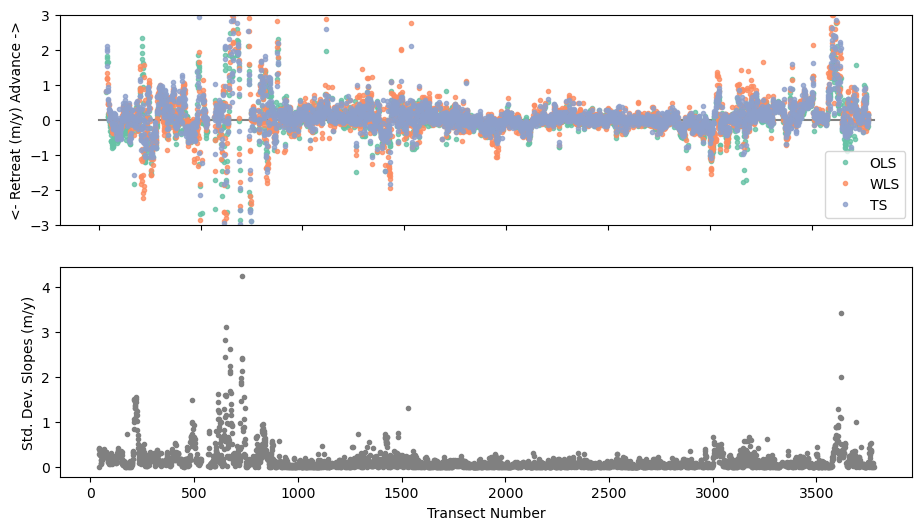

In [7]:
colors =['#66c2a5','#fc8d62','#8da0cb']
fig, (ax0, ax1) = plt.subplots(2, 1, figsize = (11,6) )
ax0.plot([0, 3800],[0,0],'-',c='gray')
ax0.plot(dft['transect'],dft['OLS slope'],'.', c=colors[0], alpha=.8, label='OLS')
ax0.plot(dft['transect'],dft['WLS slope'],'.', c=colors[1], alpha=.8, label='WLS')
ax0.plot(dft['transect'],dft['TS slope'],'.', c=colors[2], alpha=.8, label='TS')
ax0.set_ylabel('<- Retreat (m/y) Advance ->')
ax0.set_ylim(-3, 3)
ax0.set_xticklabels([])
ax0.legend()
ax1.plot(dft['transect'],dft['slope std_dev'],'.',c='gray')
ax1.set_xlabel('Transect Number')
ax1.set_ylabel('Std. Dev. Slopes (m/y)')
fig_name = fn.replace(".csv", "slopes_std.png")
plt.savefig(data_dir+fig_name, dpi=200, bbox_inches='tight')

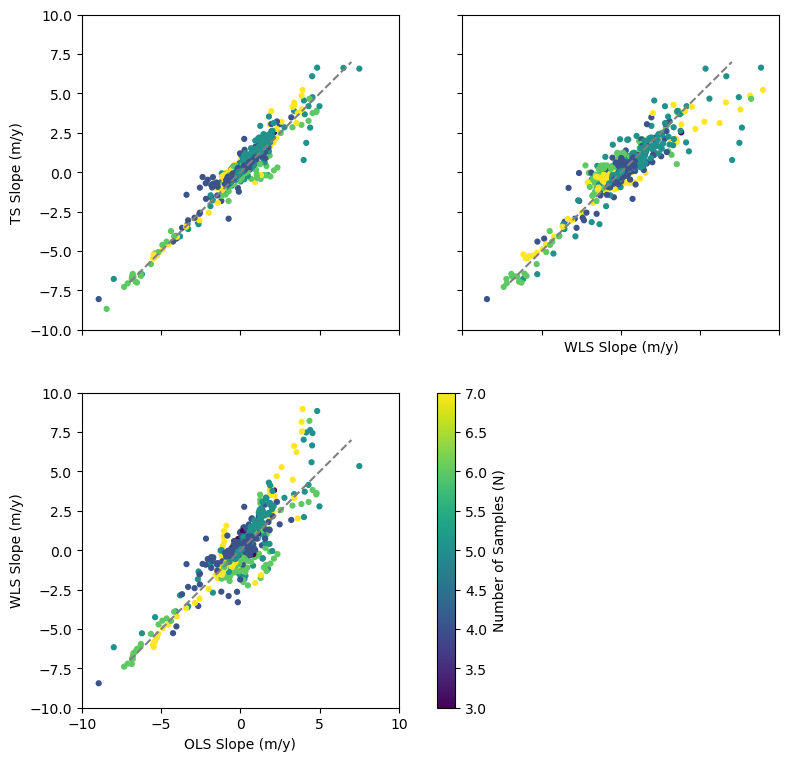

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(9, 9), sharex=True, sharey=True)

# First subplot
axs[0, 0].plot([-7, 7], [-7, 7], '--', c='gray')
sc1 = axs[0, 0].scatter(dft['OLS slope'], dft['TS slope'], s=12, c=dft['N'])
axs[0, 0].set_ylim(-10, 10)
axs[0, 0].set_xlim(-10, 10)
axs[0, 0].set_ylabel('TS Slope (m/y)')

# Second subplot
axs[1, 0].plot([-7, 7], [-7, 7], '--', c='gray')
sc2 = axs[1, 0].scatter(dft['OLS slope'], dft['WLS slope'], s=12, c=dft['N'])
axs[1, 0].set_ylim(-10, 10)
axs[1, 0].set_xlim(-10, 10)
axs[1, 0].set_ylabel('WLS Slope (m/y)')
axs[1, 0].set_xlabel('OLS Slope (m/y)')

# Third subplot (store handle for colorbar)
axs[0, 1].plot([-7, 7], [-7, 7], '--', c='gray')
im = axs[0, 1].scatter(dft['WLS slope'], dft['TS slope'], s=12, c=dft['N'])
axs[0, 1].set_ylim(-10, 10)
axs[0, 1].set_xlim(-10, 10)
axs[0, 1].set_xlabel('WLS Slope (m/y)')

# Turn off last subplot
axs[1, 1].set_axis_off()
# **Create a colorbar with controlled size**
cbar_ax = fig.add_axes([0.52, 0.11, 0.02, 0.35])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Number of Samples (N)')


fig_name = fn.replace(".csv", "slope_scatter.png")
plt.savefig(data_dir+'/plots/'+fig_name, dpi=200, bbox_inches='tight')

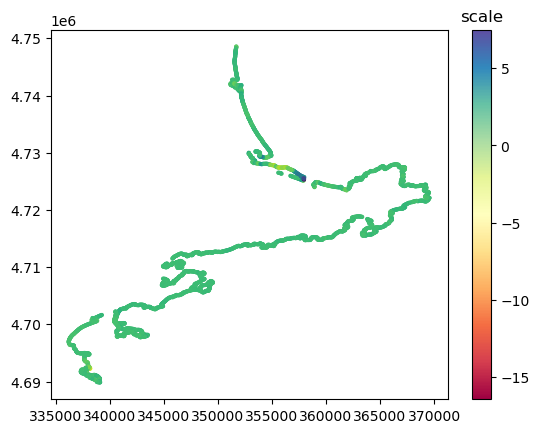

In [9]:
from matplotlib.cm import ScalarMappable
fig, ax = plt.subplots(1, 1)
cmap = plt.get_cmap("Spectral")
slopes = dft['OLS slope']
norm = plt.Normalize(slopes.min(), slopes.max())
#norm = plt.Normalize(-1, 1 )
plt.scatter( dft['Longitude'], dft['Latitude'],s=4, c=dft['OLS slope'] )
sm =  ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.ax.set_title("scale")
fig_name = fn.replace(".csv", "slope_map.png")
plt.savefig(data_dir+'/plots/'+fig_name, dpi=200, bbox_inches='tight')

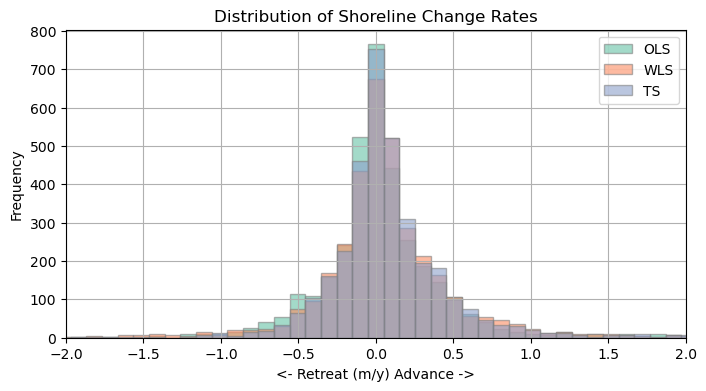

In [10]:
# Get group names and define colors

colors =['#66c2a5','#fc8d62','#8da0cb']
bins = np.linspace( -5, 5, 100 )

ax = dft['OLS slope'].hist(figsize=(8, 4), edgecolor='gray', bins=bins, color=colors[0], alpha = .6, label = 'OLS' )
ax = dft['WLS slope'].hist(figsize=(8, 4), edgecolor='gray', bins=bins, color=colors[1], alpha = .6, label = 'WLS' )
ax = dft['TS slope'].hist(figsize=(8, 4), edgecolor='gray', bins=bins, color=colors[2], alpha = .6, label = 'TS')
plt.xlim(-2, 2)
plt.legend()

# Add a legend
#ax.legend(group_name)

# Add a title and axis label
ax.set_title('Distribution of Shoreline Change Rates')
ax.set_xlabel('<- Retreat (m/y) Advance ->')
ax.set_ylabel('Frequency')
fig_name = fn.replace(".csv", "slopes_hist.png")
plt.savefig(data_dir+'/plots/'+fig_name, dpi=200, bbox_inches='tight')

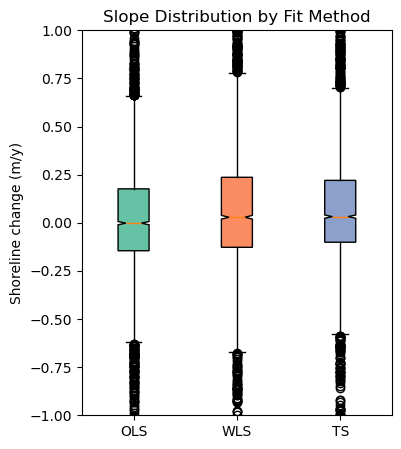

In [11]:
# boxplots of slope distributions
slopes = [ dft['OLS slope'], dft['WLS slope'], dft['TS slope'] ]
labels = ['OLS', 'WLS', 'TS']
fig, ax = plt.subplots(figsize = (4, 5) )
ax.set_ylabel('Shoreline change (m/y)')

bplot = ax.boxplot(slopes, notch=True,
                   patch_artist=True,  # fill with color
                   tick_labels=labels)  # will be used to label x-ticks

# fill with colors
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim( -1, 1 )
plt.title('Slope Distribution by Fit Method')
fig_name = fn.replace(".csv", "slopes_box.png")
plt.savefig(data_dir+'/plots/'+fig_name, dpi=200, bbox_inches='tight')